In [5]:
import numpy as np
import datetime as dt
import pytz
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 #Make pdf text editable
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
import ks_custom as ksc
import keras_tuner as kt
#from keras.utils.generic_utils import get_custom_objects
import sklearn as skl
import joblib
import scipy.stats as sps

datapath = './' #Point at my SCC data folder
os.environ['SPEDAS_DATA_DIR'] = datapath #Point SPEDAS at this folder

#Fix Random Seed
seed = 888 #Lucky!
tf.random.set_seed(seed) #Seed the TF generator
np.random.seed(seed) #Seed the NP generator

#Register the swish function in a layer object
#get_custom_objects().update({'swish': ks.layers.Activation(ks.activations.swish)})

#Assign the job to whatever GPU we were given
#def get_n_cores():
#    """The NSLOTS variable, If NSLOTS is not defined throw an exception."""
#    nslots = os.getenv("NSLOTS")
#    if nslots is not None:
#        return int(nslots)
#    raise ValueError("Environment variable NSLOTS is not defined.")

##More SCC specific boilerplate to ensure we're using as many GPUs as we're given in the optimal mode
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

#NUM_GPUS = len(tf.config.experimental.list_physical_devices("GPU"))
#print("Num GPUs Available: ", NUM_GPUS)
#if NUM_GPUS > 0:
#    print(os.getenv("CUDA_VISIBLE_DEVICES"))

tf.config.set_soft_device_placement(True)
tf.keras.backend.set_floatx("float32")
tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(get_n_cores())

#Color and style
c1 = '#E76F51'
c2 = '#F4A261'
c3 = '#E9C46A'
c4 = '#2A9D8F'
c5 = '#264653'

taikonaut_colors = [(38/255.0, 70/255.0, 83/255.0),
                  (42/255.0, 157/255.0, 143/255.0),
                  (233/255.0, 196/255.0, 106/255.0),
                  (244/255.0, 162/255.0, 97/255.0),
                  (231/255.0, 111/255.0, 81/255.0)]
taikonaut = LinearSegmentedColormap.from_list('taikonaut', taikonaut_colors, N=10000)

rb_colors = [(183/255.0, 9/255.0, 76/255.0),
             (137/255.0, 43/255.0, 100/255.0),
             (92/255.0, 77/255.0, 125/255.0),
             (46/255.0, 111/255.0, 149/255.0),
             (0/255.0, 145/255.0, 173/255.0)]
rb = LinearSegmentedColormap.from_list('rb', rb_colors, N=10000)

ModuleNotFoundError: No module named 'tensorflow'

## Load Raw Datasets
Load MMS target and Wind input datasets

In [4]:
#Target Dataset
mms_data = pd.read_hdf(datapath + 'sw_data.h5', key = 'mms_target', mode = 'a')
mms_data = ksc.nightside_cut(mms_data[mms_data['time'] <= 1617494401.617]) #Cut out the nightside data since we don't really care about it.
mms_ms = mms_data.drop(mms_data[mms_data['regid']!=0].index).dropna() #Magnetosphere data
mms_sh = mms_data.drop(mms_data[mms_data['regid']!=1].index).dropna() #Sheath data
mms_sw = mms_data.drop(mms_data[mms_data['regid']!=2].index).dropna() #Solar Wind Data

#Input Datatset
wind_data = pd.read_hdf(datapath + 'sw_data.h5', key = 'rnn_input_clean', mode = 'a')
wind_sh_ind = ksc.closest_argmin(mms_sh['time'].to_numpy(), wind_data['time'].to_numpy()) #Get the indices of the wind dataset closest to each target time
wind_ms_ind = ksc.closest_argmin(mms_ms['time'].to_numpy(), wind_data['time'].to_numpy())
wind_sw_ind = ksc.closest_argmin(mms_sw['time'].to_numpy(), wind_data['time'].to_numpy())

## Dataset Hyperparameter Tuning
Tune window size, stride, interpolation threshold. Or simply load the datasets with the optimal parameters!

In [5]:
#This takes a while, so we can just load the optimal parameters ahead of time. Set ds_hp_tune=True to actually do the search
ds_hp_tune = False
WINDOW = 200
STRIDE = 30
FLAG = 'tdelt'
INTER_FRAC = 17

if not ds_hp_tune:
    tar_sw, in_sw, tar_sw_sc, in_sw_sc, ds_mask = ksc.ds_constructor(mms_sw, wind_data, wind_sw_ind, window = WINDOW, stride = STRIDE, inter_thresh = INTER_FRAC, tar_scaler = skl.preprocessing.RobustScaler(), in_scaler = skl.preprocessing.RobustScaler(), return_mask = True, flag = FLAG) #Scale, stride, window the datasets
    in_sw_train, in_sw_test = ksc.chunker(in_sw, WINDOW*2, 0.2) #Divide the input datasets into independent chunks
    tar_sw_train, tar_sw_test= ksc.chunker(tar_sw, WINDOW*2, 0.2) #Divide the target datasets into independent chunks, save indices so we can do comparison/validation
    inds_train, inds_test = ksc.chunker(np.arange(len(tar_sw)), WINDOW*2, 0.2)

if ds_hp_tune:
    windows = [200]
    strides = [30]
    fractions = [16, 17, 18, 19, 20, 21, 22]

    hp_record = pd.DataFrame(columns = ['window', 'stride', 'fraction', 'loss', 'val_loss'], dtype = object)
    datastore = pd.HDFStore(datapath + 'hyperparameters.h5')
    for WINDOW in windows:
        for STRIDE in strides:
            for INTER_FRAC in fractions:
                tar_sw, in_sw, tar_sw_sc, in_sw_sc, ds_mask = ksc.ds_constructor(mms_sw, wind_data, wind_sw_ind, window = WINDOW, stride = STRIDE, inter_thresh = INTER_FRAC, tar_scaler = skl.preprocessing.RobustScaler(), in_scaler = skl.preprocessing.RobustScaler(), return_mask = True, flag = FLAG) #Scale, stride, window the datasets
                in_sw_train, in_sw_test = ksc.chunker(in_sw, WINDOW*2, 0.2) #Divide the input datasets into independent chunks
                tar_sw_train, tar_sw_test= ksc.chunker(tar_sw, WINDOW*2, 0.2) #Divide the target datasets into independent chunks, save indices so we can do comparison/validation
                inds_train, inds_test = ksc.chunker(np.arange(len(tar_sw)), WINDOW*2, 0.2)
                model = ks.Sequential([ks.layers.GRU(units=320),
                                       ks.layers.LayerNormalization(),
                                       ks.layers.Dropout(0.5),
                                       ks.layers.Dense(units=64, activation='elu'),
                                       ks.layers.LayerNormalization(),
                                       ks.layers.Dropout(0.5),
                                       ks.layers.Dense(units=128, activation='elu'),
                                       ks.layers.LayerNormalization(),
                                       ks.layers.Dropout(0.5),
                                       ks.layers.Dense(16,activation='linear'),
                                       ksc.GaussianLayer_relu(relu_del = 0.1)
                                      ])
                #Compile the model with an optimization routine and a loss function
                model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=ksc.negative_gaussian_loss)
                history = model.fit(in_sw_train, tar_sw_train, epochs=10, validation_split = 0.25)
                hist = pd.DataFrame(history.history)
                staging_arr = np.asarray([WINDOW, STRIDE, INTER_FRAC, hist['loss'][9], hist['val_loss'][9]])
                staging = pd.DataFrame([staging_arr], columns = ['window', 'stride', 'fraction', 'loss', 'val_loss'])
                hp_record = hp_record.append(staging, ignore_index = True)
                #hp_record.to_hdf(datapath + 'hyperparameters.h5', key = 'hp_dataset_20201101')

C:\Users\conno\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


## Model Hyperparameter Tuning
Tune the hyperparameters of the specific model we're using.

In [ ]:
#Debug model
model = ks.Sequential([ks.layers.GRU(units=256),
                           #ks.layers.LayerNormalization(),
                           #ks.layers.Dropout(0.2),
                           ks.layers.Dense(units=112, activation='elu'),
                           ks.layers.Dense(units=112, activation='elu'),
                           ks.layers.LayerNormalization(),
                           ks.layers.Dropout(0.2),
                           ks.layers.Dense(16,activation='linear'),
                           ksc.GaussianLayer(activation = 'sigmoid')
                          ])
model.compile(optimizer=tf.optimizers.Adamax(learning_rate=1e-5), loss=ksc.continuous_rank_prob)

history = model.fit(in_sw_train, tar_sw_train, epochs=50, validation_split = 0.25)
hist = pd.DataFrame(history.history) #Get the training and validation losses
plt.plot(hist['loss'],color='r') #Training loss
plt.plot(hist['val_loss'],color='b') #Validation loss
#plt.vlines(min_epoch,np.min(hist.to_numpy()),np.max(hist.to_numpy()),color=sw.b)
plt.ylabel('Loss')
plt.xlabel('Epoch (Training iteration)')
plt.legend(['Training','Validation'])

INFO:tensorflow:Reloading Oracle from existing project /projectnb/sw-prop/obrienco/smokesite/gru_sw_08/oracle.json
INFO:tensorflow:Reloading Tuner from /projectnb/sw-prop/obrienco/smokesite/gru_sw_08/tuner0.json
INFO:tensorflow:Oracle triggered exit

    The hyperparameter search is complete. The optimal number of units in the GRU
    layer is 416, the optimal number of units in the first densely-connected
    layer is 96, the optimal number of units in the second densely-connected
    layer is 112, the optimal dropout rate is 0.2, and 
    the optimal learning rate for the optimizer is 0.001.
    
Epoch 1/15
1371/1371 [==============================] - 30s 19ms/step - loss: 0.3358 - val_loss: 0.2437
Epoch 2/15
1371/1371 [==============================] - 23s 16ms/step - loss: 0.2891 - val_loss: 0.2628
Epoch 3/15
1371/1371 [==============================] - 25s 18ms/step - loss: 0.2601 - val_loss: 0.2871
Epoch 4/15
1371/1371 [==============================] - 25s 18ms/step - loss: 0.23

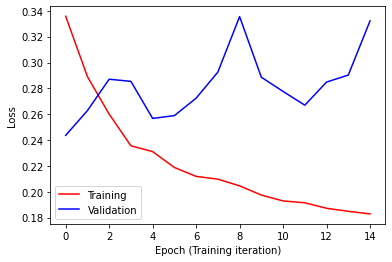

In [5]:
#Define the model
def model_builder(hp):
    hp_units0 = hp.Int('units0', min_value=128, max_value=640, step=32) #Units in the first (recurrent) layer
    hp_units1 = hp.Int('units1', min_value=16, max_value=128, step=16) #Units in the second (dense) layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=128, step=16) #Units in the third (dense) layer
    hp_drop_rate = hp.Choice('drop_rate', values = [0.2,0.35,0.5]) #Rate of node dropout
    #relu_del = hp.Choice('relu_del', values = [1e-1, 1e-2, 1e-3]) #Modified RELU floor (e.g. relu(x) = max(relu_del, x))
    model = ks.Sequential([ks.layers.GRU(units=hp_units0),
                           ks.layers.LayerNormalization(),
                           ks.layers.Dropout(hp_drop_rate),
                           ks.layers.Dense(units=hp_units1, activation='elu'),
                           ks.layers.LayerNormalization(),
                           ks.layers.Dropout(hp_drop_rate),
                           ks.layers.Dense(units=hp_units2, activation='elu'),
                           ks.layers.LayerNormalization(),
                           ks.layers.Dropout(hp_drop_rate),
                           ks.layers.Dense(16,activation='linear'),
                           ksc.GaussianLayer(activation = 'sigmoid')
                          ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4]) #Learning rate of Adam
    #Compile the model with an optimization routine and a loss function
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate), loss=ksc.continuous_rank_prob)
    return model

#Make the hyperparemeter tuner
name = 'gru_sw_09' #Name of the training run to be saved (if train) or loaded (if not train)
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs = 150,
                     factor = 3,
                     directory = datapath+'smokesite',
                     project_name = name)
#name = 'gru_sw_08' #Name of the training run to be saved (if train) or loaded (if not train)
#tuner = kt.RandomSearch(model_builder,
#                        objective='val_loss',
#                        max_trials = 150,
#                        seed = seed,
#                        directory = datapath+'smokesite',
#                        project_name = name)


load_model = False
if load_model:
    model_opt = ks.models.load_model(datapath + 'models/'+name, custom_objects={'negative_gaussian_loss': ksc.continuous_rank_prob})
    in_sw_sc = joblib.load(datapath+'models/'+name+'_iscale') #Load in the scalers for the target and input data
    tar_sw_sc = joblib.load(datapath+'models/'+name+'_tscale')
else:
    #Callback to stop early in case we just sit around
    #stop_early = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    #Get the optimal hyperparameters, either by loading a hyperparameter search or if none exists executing the search from scratch
    tuner.search(in_sw_train, tar_sw_train, validation_split = 0.25)#, callbacks=[stop_early])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] #These are the hyperparameters one can build the optimal model with

    #Output the hyperparameters in user-readable format
    print(f"""
    The hyperparameter search is complete. The optimal number of units in the GRU
    layer is {best_hps.get('units0')}, the optimal number of units in the first densely-connected
    layer is {best_hps.get('units1')}, the optimal number of units in the second densely-connected
    layer is {best_hps.get('units2')}, the optimal dropout rate is {best_hps.get('drop_rate')}, and 
    the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
    """)

    #Build the model with optimal hyperparameters
    model_opt = tuner.hypermodel.build(best_hps)
    #Fit the model
    history = model_opt.fit(in_sw_train, tar_sw_train, epochs=15, validation_split = 0.25)
    #Get the training and validation losses
    hist = pd.DataFrame(history.history)
    #Find the point where overfitting begins to occur
    min_epoch = hist['val_loss'].idxmin()

    #Get the performance of the model on the test set for later
    test_results= model_opt.evaluate(in_sw_test, tar_sw_test, verbose=0)
    #model_opt.save(datapath+'models/'+name)
    #joblib.dump(in_sw_sc, datapath+'models/'+name+'_iscale') #Save the input scaler
    #joblib.dump(tar_sw_sc, datapath+'models/'+name+'_tscale') #Save the target scaler
    #Plot the validation and training losses to evaluate if overfitting occurred
    plt.plot(hist['loss'],color='r') #Training loss
    plt.plot(hist['val_loss'],color='b') #Validation loss
    #plt.vlines(min_epoch,np.min(hist.to_numpy()),np.max(hist.to_numpy()),color=sw.b)
    plt.ylabel('Loss')
    plt.xlabel('Epoch (Training iteration)')
    plt.legend(['Training','Validation'])

## Model Outputs
Generate model outputs for future comparison.

In [7]:
load = True #Switch to load saved predictions or make new ones (GPU frequently runs out of memory if fed the full wind data array)

if load:
    predict = pd.read_hdf(datapath + 'sw_data.h5', key = 'gru_predict')
    predict_bs = pd.read_hdf(datapath + 'sw_data.h5', key = 'gru_predict_bs')
    predict_test = pd.read_hdf(datapath + 'sw_data.h5', key = 'gru_predict_test')
    
if not load:
    #Create predictions for the test dataset
    mms_test = mms_sw[ds_mask]
    mms_test = mms_test.iloc[inds_test]
    predict_test_arr = model_opt.predict(in_sw_test)
    predict_test = pd.DataFrame(columns = ['time', 'Bx_gsm', 'Bx_gsm_sig', 'By_gsm', 'By_gsm_sig', 'Bz_gsm', 'Bz_gsm_sig', 'Vx_gse', 'Vx_gse_sig', 'Vy_gse', 'Vy_gse_sig', 'Vz_gse', 'Vz_gse_sig', 'n_i', 'n_i_sig', 'T_i', 'T_i_sig', 'interp_frac'])
    predict_test['time'] = mms_test['time']
    predict_test['interp_frac'] = -1 #find a good way to grab the interpolated fration at this step
    predict_test[['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']] = tar_sw_sc.inverse_transform(predict_test_arr[:, ::2])
    predict_test[['Bx_gsm_sig', 'By_gsm_sig', 'Bz_gsm_sig', 'Vx_gse_sig', 'Vy_gse_sig', 'Vz_gse_sig', 'n_i_sig', 'T_i_sig']] = np.abs(tar_sw_sc.inverse_transform(predict_test_arr[:, ::2] + predict_test_arr[:, 1::2]) - tar_sw_sc.inverse_transform(predict_test_arr[:, ::2]))
    predict_test.to_hdf(datapath + 'sw_data.h5', key = 'gru_predict_test')
    
    #Make predictions on full dataset (train + test)
    predict_arr = np.zeros((len(in_sw), 16)) #Stage the prediction array
    n = 1000
    for i in np.arange(len(predict_arr)//n+1):
        predict_arr[i*n:(i+1)*n, :] = model_opt.predict(in_sw[i*n:(i+1)*n, :, :])
        print(str(100*i/(len(predict_arr)//n))[0:5]+'% Complete', end = '\r')
    predict = pd.DataFrame(columns = ['time', 'Bx_gsm', 'Bx_gsm_sig', 'By_gsm', 'By_gsm_sig', 'Bz_gsm', 'Bz_gsm_sig', 'Vx_gse', 'Vx_gse_sig', 'Vy_gse', 'Vy_gse_sig', 'Vz_gse', 'Vz_gse_sig', 'n_i', 'n_i_sig', 'T_i', 'T_i_sig', 'interp_frac'])
    predict['time'] = wind_data['time'].iloc[wind_sw_ind][ds_mask]
    predict['interp_frac'] = -1 #find a good way to grab the interpolated fration at this step
    predict[['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']] = tar_sw_sc.inverse_transform(predict_arr[:, ::2])
    predict[['Bx_gsm_sig', 'By_gsm_sig', 'Bz_gsm_sig', 'Vx_gse_sig', 'Vy_gse_sig', 'Vz_gse_sig', 'n_i_sig', 'T_i_sig']] = np.abs(tar_sw_sc.inverse_transform(predict_arr[:, ::2] + predict_arr[:, 1::2]) - tar_sw_sc.inverse_transform(predict_arr[:, ::2]))
    predict.to_hdf(datapath + 'sw_data.h5', key = 'gru_predict')
    
    wind_data_rs = wind_data.copy() #Make a new dataframe to use as input to model
    wind_data_train, wind_data_test = ksc.chunker(wind_data_rs, WINDOW*2, 0.2) #Recreate the train and test sets
    
    #Create predictions at the bow shock for the time interval considered in this study
    wind_data_rs['target_Px_gse'] = 6378*13.25 #Point the target at a fixed point (average BS nose location)
    wind_data_rs['target_Py_gse'] = 0
    wind_data_rs['target_Pz_gse'] = 0
    wind_data_rs.index = np.arange(len(wind_data_rs)) #make the indes linear
    wind_data_rs.iloc[:,1:15] = in_sw_sc.transform(wind_data.iloc[:,1:15]) #Rescale the data
    inds = np.arange(WINDOW+STRIDE, len(wind_data_rs)) #Indices to start each time series at
    wind_data_rs_arr, flags = ksc.input_window(wind_data_rs, inds, WINDOW, STRIDE) #Break the array into input timeseries
    predict_arr = np.zeros((len(wind_data_rs_arr), 16)) #Stage the prediction array
    n = 1000
    for i in np.arange(len(predict_arr)//n+1):
        predict_arr[i*n:(i+1)*n, :] = model_opt.predict(wind_data_rs_arr[i*n:(i+1)*n, :, :])
        print(str(100*i/(len(predict_arr)//n))[0:5]+'% Complete', end = '\r')
    predict = pd.DataFrame(columns = ['time', 'Bx_gsm', 'Bx_gsm_sig', 'By_gsm', 'By_gsm_sig', 'Bz_gsm', 'Bz_gsm_sig', 'Vx_gse', 'Vx_gse_sig', 'Vy_gse', 'Vy_gse_sig', 'Vz_gse', 'Vz_gse_sig', 'n_i', 'n_i_sig', 'T_i', 'T_i_sig', 'interp_frac'])
    predict['time'] = wind_data_rs['time'][(WINDOW+STRIDE):]
    predict['interp_frac'] = flags
    predict[['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']] = tar_sw_sc.inverse_transform(predict_arr[:, ::2])
    predict[['Bx_gsm_sig', 'By_gsm_sig', 'Bz_gsm_sig', 'Vx_gse_sig', 'Vy_gse_sig', 'Vz_gse_sig', 'n_i_sig', 'T_i_sig']] = np.abs(tar_sw_sc.inverse_transform(predict_arr[:, ::2] + predict_arr[:, 1::2]) - tar_sw_sc.inverse_transform(predict_arr[:, ::2]))
    predict.to_hdf(datapath + 'sw_data.h5', key = 'gru_predict_bs')

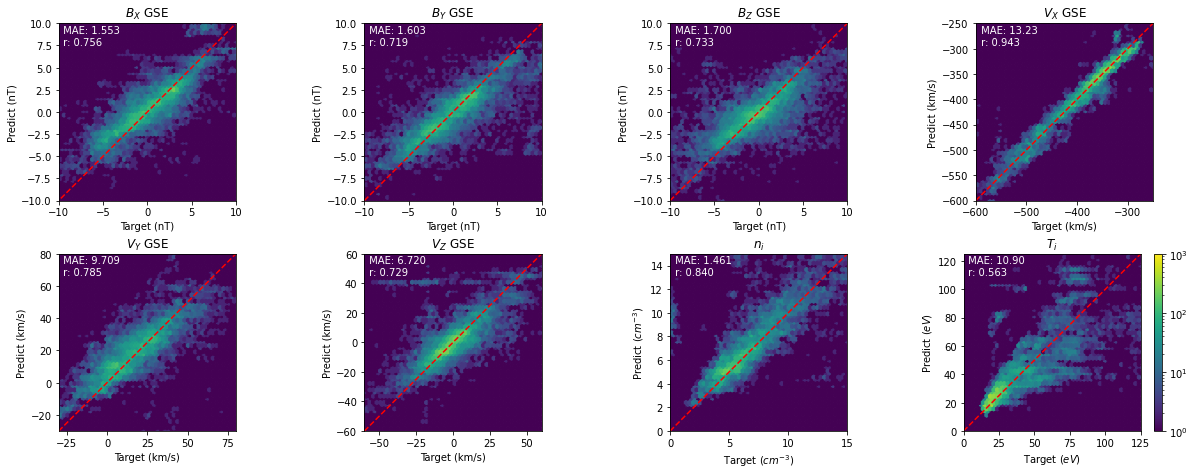

In [9]:
#Make 2D comparison histograms
mms_test = mms_sw[ds_mask] #The easy two step process to get mms test set data in units
mms_test = mms_test.iloc[inds_test]
omni_test = pd.read_hdf(datapath+'sw_data.h5', key = 'wind_kp_shift') #load shifted omni data
omni_test = omni_test.iloc[ksc.closest_argmin(mms_test['time'].to_numpy(), omni_test['time'].to_numpy())] #and cut that omni so it's just the test set

nbins = 50
keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']
omni_keys = ['BX_GSE', 'BY_GSM', 'BZ_GSM', 'VX_GSE', 'VY_GSE', 'VZ_GSE', 'proton_density', 'T']
bounds = [[-10, 10], [-10, 10], [-10, 10], [-600, -250], [-30, 80], [-60, 60], [0, 15], [0, 125]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE',r'$n_{i}$',r'$T_{i}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$',r'$eV$']
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(21, 7.5)
plt.subplots_adjust(hspace = 0.3)
for idx, key in enumerate(keys):
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im = ax[idx//4,idx%4].hexbin(mms_test[key], predict_test[key], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]))
    ax[idx//4, idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4, idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('Predict ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx])
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    ax[idx//4,idx%4].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'w')
plt.colorbar(im)
#plt.savefig('GRU_v05_hist_zoom.pdf',bbox_inches='tight')

ValueError: array must not contain infs or NaNs

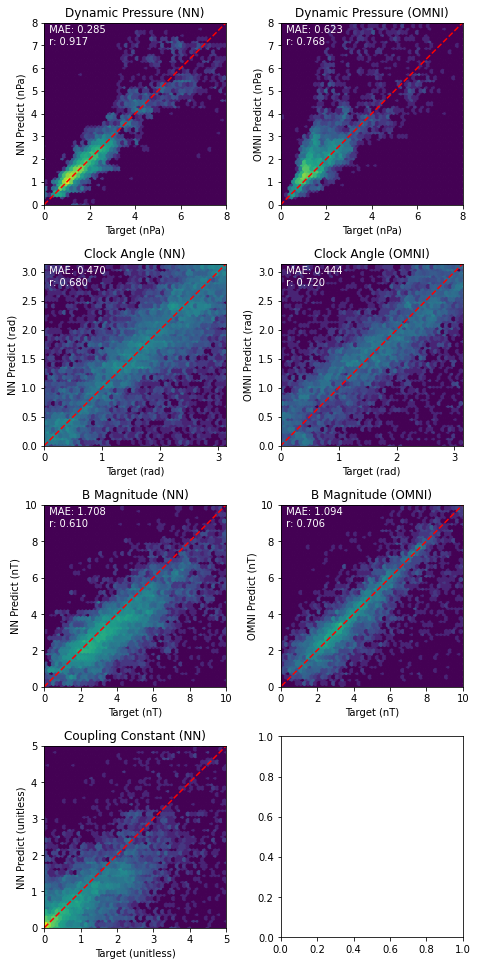

In [54]:
mms_theta = np.arctan2(mms_test['By_gsm'], mms_test['Bz_gsm']) #Clock angle
mms_B = np.sqrt(mms_test['Bx_gsm']**2 + mms_test['By_gsm']**2 + mms_test['Bz_gsm']**2) #total B field
mms_BT = np.sqrt(mms_test['By_gsm']**2 + mms_test['Bz_gsm']**2) #tangential B field
mms_V = np.sqrt(mms_test['Vx_gse']**2 + mms_test['Vy_gse']**2 + mms_test['Vz_gse']**2) #total V
mms_MA = 0.04585 * mms_V * (mms_test['n_i']**0.5) / mms_B #Alfven Mach number
mms_couple = (np.sin(mms_theta/2)**2) * (mms_test['n_i']**(0.24)) * (mms_V**(1.49)) * (mms_BT**(0.51))/100
mms_couple = mms_couple.where((mms_MA <= 6), (np.sin(mms_theta/2)**2) * (mms_test['n_i']**(-0.19)) * (mms_V**(0.62)) * (mms_BT**(1.38)))/100
mms_pdyn = mms_test['n_i'] * (mms_test['Vx_gse']**2 + mms_test['Vy_gse']**2 + mms_test['Vz_gse']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#mms_couple = mms_pdyn * mms_B *(np.sin(mms_theta/2)**6) / (mms_test['n_i']**0.5)

predict_theta = np.arctan2(predict_test['By_gsm'], predict_test['Bz_gsm']) #Clock angle
predict_B = np.sqrt(predict_test['Bx_gsm']**2 + predict_test['By_gsm']**2 + predict_test['Bz_gsm']**2) #total B field
predict_BT = np.sqrt(predict_test['By_gsm']**2 + predict_test['Bz_gsm']**2) #tangential B field
predict_V = np.sqrt(predict_test['Vx_gse']**2 + predict_test['Vy_gse']**2 + predict_test['Vz_gse']**2) #total V
predict_MA = 0.04585 * predict_V * (predict_test['n_i']**0.5) / predict_B #Alfven Mach number
predict_couple = (np.sin(predict_theta/2)**2) * (predict_test['n_i']**(0.24)) * (predict_V**(1.49)) * (predict_BT**(0.51))/100
predict_couple = predict_couple.where((predict_MA <= 6), (np.sin(predict_theta/2)**2) * (predict_test['n_i']**(-0.19)) * (predict_V**(0.62)) * (predict_BT**(1.38)))/100
predict_pdyn = predict_test['n_i'] * (predict_test['Vx_gse']**2 + predict_test['Vy_gse']**2 + predict_test['Vz_gse']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#predict_couple = predict_pdyn * predict_B *(np.sin(predict_theta/2)**6) / (predict_test['n_i']**0.5)

omni_test = pd.read_hdf(datapath+'sw_data.h5', key = 'wind_kp_shift') #load shifted omni data
omni_test = omni_test.iloc[ksc.closest_argmin(mms_test['time'].to_numpy(), omni_test['time'].to_numpy())] #and cut that omni so it's just the test set
cut = (omni_test['BX_GSE'] < 999.9) & (omni_test['BY_GSM'] < 999.9) & (omni_test['BZ_GSM'] < 999.9) & (omni_test['VX_GSE'] < 9999.9) & (omni_test['VY_GSE'] < 9999.9) & (omni_test['VZ_GSE'] < 9999.9) & (omni_test['proton_density'] < 999.9) & (omni_test['T'] < 9999999.0) & (~omni_test.index.duplicated())
omni_theta = np.arctan2(omni_test['BY_GSM'], omni_test['BZ_GSM']) #Clock angle
omni_B = np.sqrt(omni_test['BX_GSE']**2 + omni_test['BY_GSM']**2 + omni_test['BZ_GSM']**2) #total B field
omni_BT = np.sqrt(omni_test['BY_GSM']**2 + omni_test['BZ_GSM']**2) #tangential B field
omni_V = np.sqrt(omni_test['VX_GSE']**2 + omni_test['VY_GSE']**2 + omni_test['VZ_GSE']**2) #total V
omni_MA = 0.04585 * omni_V * (omni_test['proton_density']**0.5) / omni_B #Alfven Mach number
omni_couple = (np.sin(omni_theta/2)**2) * (omni_test['proton_density']**(0.24)) * (omni_V**(1.49)) * (omni_BT**(0.51))/100
omni_couple = omni_couple.where((omni_MA <= 6), (np.sin(omni_theta/2)**2) * (omni_test['proton_density']**(-0.19)) * (omni_V**(0.62)) * (omni_BT**(1.38)))/100
omni_pdyn = omni_test['proton_density'] * (omni_test['VX_GSE']**2 + omni_test['VY_GSE']**2 + omni_test['VZ_GSE']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#omni_couple = omni_pdyn * omni_B *(np.sin(omni_theta/2)**6) / (omni_test['proton_density']**0.5)

    
fig, ax = plt.subplots(nrows = 4, ncols = 2)
plt.subplots_adjust(wspace = 0.3)
fig.set_size_inches(7.5, 17)
bins = np.linspace(0, 8, nbins)
im = ax[0, 0].hexbin(mms_pdyn, predict_pdyn, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[0, 0].set_xlim(bins[0], bins[-1])
ax[0, 0].set_ylim(bins[0], bins[-1])
ax[0, 0].set_aspect('equal')
ax[0, 0].set_xlabel('Target (nPa)')
ax[0, 0].set_ylabel('NN Predict (nPa)')
ax[0, 0].set_title('Dynamic Pressure (NN)')
ax[0, 0].autoscale(enable=False)
ax[0, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_pdyn - mms_pdyn))
model_r, model_p = sps.pearsonr(predict_pdyn, mms_pdyn)
ax[0, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[0, 0].transAxes, color = 'w')

im = ax[0, 1].hexbin(mms_pdyn.iloc[cut.to_numpy()], omni_pdyn[cut], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[0, 1].set_xlim(bins[0], bins[-1])
ax[0, 1].set_ylim(bins[0], bins[-1])
ax[0, 1].set_aspect('equal')
ax[0, 1].set_xlabel('Target (nPa)')
ax[0, 1].set_ylabel('OMNI Predict (nPa)')
ax[0, 1].set_title('Dynamic Pressure (OMNI)')
ax[0, 1].autoscale(enable=False)
ax[0, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_pdyn[cut].to_numpy() - mms_pdyn.iloc[cut.to_numpy()].to_numpy()))
omni_r, omni_p = sps.pearsonr(omni_pdyn[cut].to_numpy(), mms_pdyn.iloc[cut.to_numpy()].to_numpy())
ax[0, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[0, 1].transAxes, color = 'w')


bins = np.linspace(0, np.pi, nbins)
im = ax[1, 0].hexbin(np.abs(mms_theta), np.abs(predict_theta), gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[1, 0].set_xlim(bins[0], bins[-1])
ax[1, 0].set_ylim(bins[0], bins[-1])
ax[1, 0].set_aspect('equal')
ax[1, 0].set_xlabel('Target (rad)')
ax[1, 0].set_ylabel('NN Predict (rad)')
ax[1, 0].set_title('Clock Angle (NN)')
ax[1, 0].autoscale(enable=False)
ax[1, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(np.abs(predict_theta) - np.abs(mms_theta)))
model_r, model_p = sps.pearsonr(np.abs(predict_theta), np.abs(mms_theta))
ax[1, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[1, 0].transAxes, color = 'w')

im = ax[1, 1].hexbin(np.abs(mms_theta.iloc[cut.to_numpy()]), np.abs(omni_theta[cut]), gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[1, 1].set_xlim(bins[0], bins[-1])
ax[1, 1].set_ylim(bins[0], bins[-1])
ax[1, 1].set_aspect('equal')
ax[1, 1].set_xlabel('Target (rad)')
ax[1, 1].set_ylabel('OMNI Predict (rad)')
ax[1, 1].set_title('Clock Angle (OMNI)')
ax[1, 1].autoscale(enable=False)
ax[1, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(np.abs(omni_theta[cut].to_numpy()) - np.abs(mms_theta.iloc[cut.to_numpy()].to_numpy())))
omni_r, omni_p = sps.pearsonr(np.abs(omni_theta[cut].to_numpy()), np.abs(mms_theta.iloc[cut.to_numpy()].to_numpy()))
ax[1, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[1, 1].transAxes, color = 'w')

bins = np.linspace(0, 10, nbins)
im = ax[2, 0].hexbin(mms_BT, predict_BT, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[2, 0].set_xlim(bins[0], bins[-1])
ax[2, 0].set_ylim(bins[0], bins[-1])
ax[2, 0].set_aspect('equal')
ax[2, 0].set_xlabel('Target (nT)')
ax[2, 0].set_ylabel('NN Predict (nT)')
ax[2, 0].set_title('B Magnitude (NN)')
ax[2, 0].autoscale(enable=False)
ax[2, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_BT - mms_BT))
model_r, model_p = sps.pearsonr(predict_BT, mms_BT)
ax[2, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[2, 0].transAxes, color = 'w')

im = ax[2, 1].hexbin(mms_BT.iloc[cut.to_numpy()], omni_BT[cut], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[2, 1].set_xlim(bins[0], bins[-1])
ax[2, 1].set_ylim(bins[0], bins[-1])
ax[2, 1].set_aspect('equal')
ax[2, 1].set_xlabel('Target (nT)')
ax[2, 1].set_ylabel('OMNI Predict (nT)')
ax[2, 1].set_title('B Magnitude (OMNI)')
ax[2, 1].autoscale(enable=False)
ax[2, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_BT[cut].to_numpy() - mms_BT.iloc[cut.to_numpy()].to_numpy()))
omni_r, omni_p = sps.pearsonr(omni_BT[cut].to_numpy(), mms_BT.iloc[cut.to_numpy()].to_numpy())
ax[2, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[2, 1].transAxes, color = 'w')

bins = np.linspace(0, 5, nbins)
im = ax[3, 0].hexbin(mms_couple, predict_couple, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[3, 0].set_xlim(bins[0], bins[-1])
ax[3, 0].set_ylim(bins[0], bins[-1])
ax[3, 0].set_aspect('equal')
ax[3, 0].set_xlabel('Target (unitless)')
ax[3, 0].set_ylabel('NN Predict (unitless)')
ax[3, 0].set_title('Coupling Constant (NN)')
ax[3, 0].autoscale(enable=False)
ax[3, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_couple - mms_couple))
model_r, model_p = sps.pearsonr(predict_couple, mms_couple)
ax[3, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[3, 0].transAxes, color = 'w')

im = ax[3, 1].hexbin(mms_couple.iloc[cut.to_numpy()], omni_couple[cut], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[3, 1].set_xlim(bins[0], bins[-1])
ax[3, 1].set_ylim(bins[0], bins[-1])
ax[3, 1].set_aspect('equal')
ax[3, 1].set_xlabel('Target (unitless)')
ax[3, 1].set_ylabel('OMNI Predict (unitless)')
ax[3, 1].set_title('Coupling Constant (OMNI)')
ax[3, 1].autoscale(enable=False)
ax[3, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_couple[cut].to_numpy() - mms_couple.iloc[cut.to_numpy()].to_numpy()))
omni_r, omni_p = sps.pearsonr(omni_couple[cut].to_numpy(), mms_couple.iloc[cut.to_numpy()].to_numpy())
ax[3, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[3, 1].transAxes, color = 'w')

#plt.savefig('poster_comp.pdf', bbox_inches = 'tight')

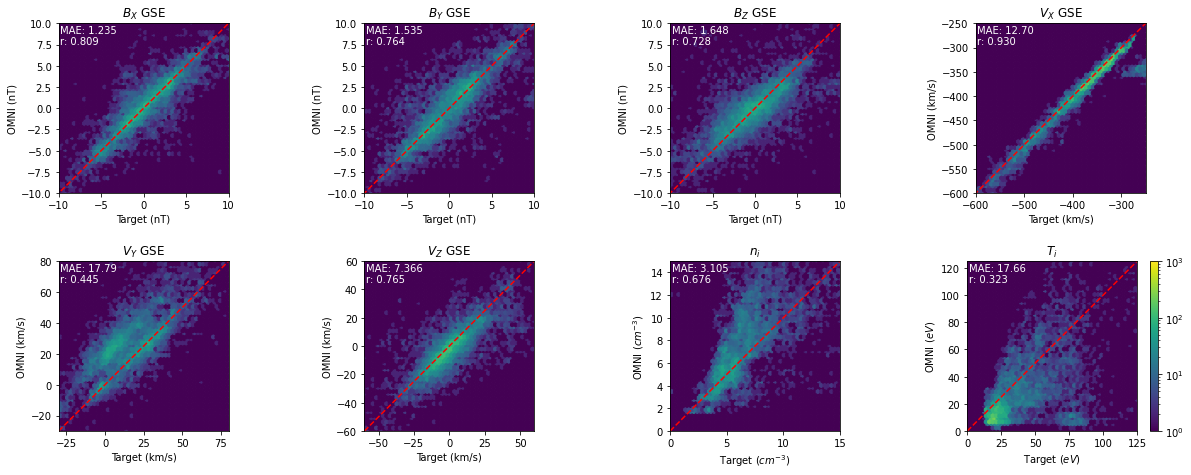

In [52]:
nbins = 50
keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']
omni_keys = ['BX_GSE', 'BY_GSM', 'BZ_GSM', 'VX_GSE', 'VY_GSE', 'VZ_GSE', 'proton_density', 'T']
bounds = [[-10, 10], [-10, 10], [-10, 10], [-600, -250], [-30, 80], [-60, 60], [0, 15], [0, 125]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE',r'$n_{i}$',r'$T_{i}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$',r'$eV$']

omni_test = pd.read_hdf(datapath+'sw_data.h5', key = 'wind_kp_shift') #load shifted omni data
omni_test = omni_test.iloc[ksc.closest_argmin(mms_test['time'].to_numpy(), omni_test['time'].to_numpy())] #and cut that omni so it's just the test set
cut = (omni_test['BX_GSE'] < 999.9) & (omni_test['BY_GSM'] < 999.9) & (omni_test['BZ_GSM'] < 999.9) & (omni_test['VX_GSE'] < 9999.9) & (omni_test['VY_GSE'] < 9999.9) & (omni_test['VZ_GSE'] < 9999.9) & (omni_test['proton_density'] < 999.9) & (omni_test['T'] < 9999999.0) & (~omni_test.index.duplicated())

fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(21, 7.5)
plt.subplots_adjust(hspace = 0.4)
for idx, key in enumerate(keys):
    pred_temp = omni_test[omni_keys[idx]][cut]
    mms_temp = mms_test[key][cut.to_numpy()]
    if key == 'Vy_gse':
        pred_temp += 30
    if key == 'T_i':
        pred_temp *= 5*8.617e-5
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im = ax[idx//4,idx%4].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]))
    ax[idx//4, idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4, idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('OMNI ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx])
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
    omni_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    omni_r, omni_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[idx//4,idx%4].text(.01, .99, 'MAE: ' + str(omni_mae)[0:5] + '\nr: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'w')
plt.colorbar(im)
#plt.savefig('OMNI_hist.pdf',bbox_inches='tight')

In [72]:
mms_test = mms_sw[ds_mask] #The easy two step process to get mms test set data in units
mms_test = mms_test.iloc[inds_test]
omni_test = pd.read_hdf(datapath+'sw_data.h5', key = 'wind_kp_shift') #load shifted omni data
omni_test = omni_test.iloc[ksc.closest_argmin(mms_test['time'].to_numpy(), omni_test['time'].to_numpy())] #and cut that omni so it's just the test set
cut = (omni_test['BX_GSE'] < 999.9) & (omni_test['BY_GSM'] < 999.9) & (omni_test['BZ_GSM'] < 999.9) & (omni_test['VX_GSE'] < 9999.9) & (omni_test['VY_GSE'] < 9999.9) & (omni_test['VZ_GSE'] < 9999.9) & (omni_test['proton_density'] < 999.9) & (omni_test['T'] < 9999999.0) & (~omni_test.index.duplicated())

total_mae = 0

for idx, key in enumerate(keys):
    model_mae = np.mean(np.abs(predict_test[key] - mms_test[key]))
    model_std = np.std(mms_sw[key])
    total_mae += model_mae/model_std
    print('Model ' + key + ' MAE: '+str(model_mae)[0:5]+' ('+str(model_mae/model_std)[0:5]+' sigma)')
total_mae /= 8
print('Model total MAE: '+str(total_mae)[0:5]+' sigma')

total_mae = 0

for idx, key in enumerate(keys):
    pred_temp = omni_test[omni_keys[idx]][cut]
    mms_temp = mms_test[key][cut.to_numpy()]
    if key == 'Vy_gse':
        pred_temp += 30
    if key == 'T_i':
        pred_temp *= 5*8.617e-5
    omni_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    omni_std = np.std(mms_sw[key])
    total_mae += omni_mae/omni_std
    print('OMNI ' + key + ' MAE: '+str(omni_mae)[0:5]+' ('+str(omni_mae/omni_std)[0:5]+' sigma)')
total_mae /= 8
print('OMNI total MAE: '+str(total_mae)[0:5]+' sigma')

Model Bx_gsm MAE: 1.842 (0.420 sigma)
Model By_gsm MAE: 1.719 (0.304 sigma)
Model Bz_gsm MAE: 1.867 (0.330 sigma)
Model Vx_gse MAE: 11.85 (0.136 sigma)
Model Vy_gse MAE: 9.144 (0.317 sigma)
Model Vz_gse MAE: 6.820 (0.383 sigma)
Model n_i MAE: 1.239 (0.267 sigma)
Model T_i MAE: 11.02 (0.294 sigma)
Model total MAE: 0.306 sigma
OMNI Bx_gsm MAE: 1.235 (0.281 sigma)
OMNI By_gsm MAE: 1.535 (0.271 sigma)
OMNI Bz_gsm MAE: 1.648 (0.291 sigma)
OMNI Vx_gse MAE: 12.70 (0.146 sigma)
OMNI Vy_gse MAE: 17.79 (0.617 sigma)
OMNI Vz_gse MAE: 7.366 (0.414 sigma)
OMNI n_i MAE: 3.105 (0.669 sigma)
OMNI T_i MAE: 17.66 (0.471 sigma)
OMNI total MAE: 0.395 sigma


In [11]:
#5min cadence test
groups_mms = mms_test.groupby(pd.cut(mms_test['time'], np.arange(int(mms_test['time'][3556])-1, int(mms_test['time'][298912])+1, 5*60)))
mms_5min = groups_mms.mean()
groups_predict = predict_test.groupby(pd.cut(predict_test['time'], np.arange(int(predict_test['time'][3556])-1, int(predict_test['time'][298912])+1, 5*60)))
predict_5min = groups_predict.mean()
groups_omni = omni_test[cut].groupby(pd.cut(omni_test['time'][cut], np.arange(int(mms_test['time'][3556])-1, int(mms_test['time'][298912])+1, 5*60)))#pd.cut(omni_test['time'][cut], np.arange(int(omni_test['time'][11301])-1, int(omni_test['time'][2825132])+1, 5*60)))
omni_5min = groups_omni.mean()
omni_5min =  omni_5min.rename(columns = {'BX_GSE':'Bx_gsm', 'BY_GSM':'By_gsm', 'BZ_GSM':'Bz_gsm', 'VX_GSE':'Vx_gse', 'VY_GSE':'Vy_gse', 'VZ_GSE':'Vz_gse', 'proton_density':'n_i', 'T':'T_i'})
nan_bool = (~np.isnan(mms_5min))&(~np.isnan(predict_5min))
nan_bool_omni = (~np.isnan(mms_5min))&(~np.isnan(omni_5min))

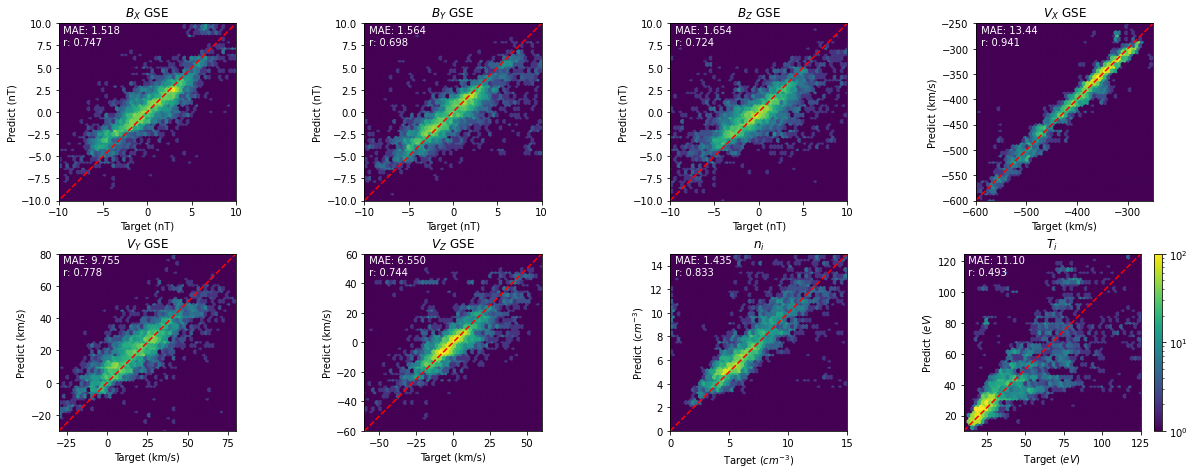

In [12]:
nbins = 50
keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']
omni_keys = ['BX_GSE', 'BY_GSM', 'BZ_GSM', 'VX_GSE', 'VY_GSE', 'VZ_GSE', 'proton_density', 'T']
bounds = [[-10, 10], [-10, 10], [-10, 10], [-600, -250], [-30, 80], [-60, 60], [0, 15], [10, 125]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE',r'$n_{i}$',r'$T_{i}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$',r'$eV$']
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(21, 7.5)
plt.subplots_adjust(hspace = 0.3)
for idx, key in enumerate(keys):
    mms_temp = mms_5min[key][nan_bool[key]]
    pred_temp = predict_5min[key][nan_bool[key]]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im = ax[idx//4,idx%4].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]))
    ax[idx//4, idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4, idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('Predict ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx])
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
    model_mae = np.mean(np.abs(pred_temp - mms_temp))
    model_r, model_p = sps.pearsonr(pred_temp, mms_temp)
    ax[idx//4,idx%4].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'w')
plt.colorbar(im)

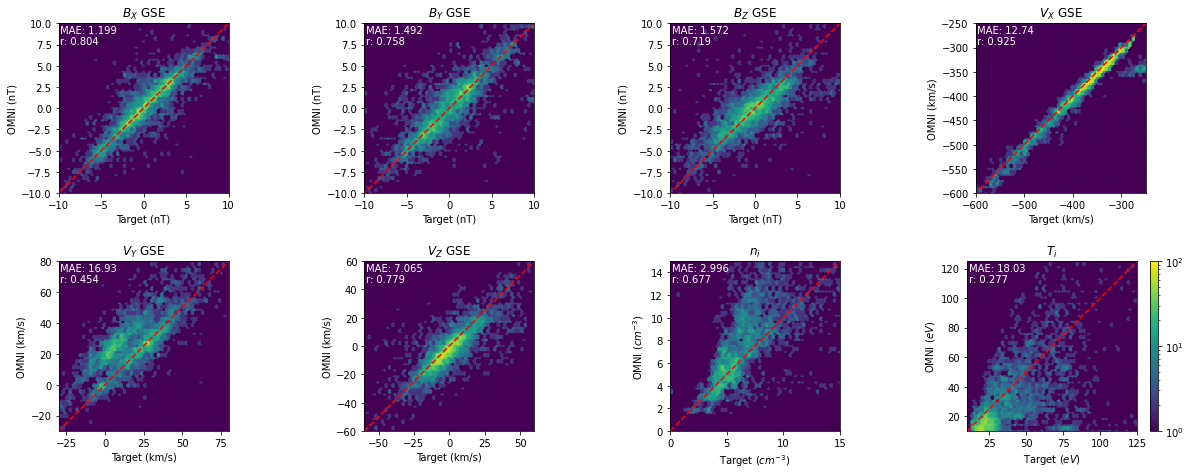

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(21, 7.5)
plt.subplots_adjust(hspace = 0.4)
for idx, key in enumerate(keys):
    mms_temp = mms_5min[key][nan_bool_omni[key]]
    pred_temp = omni_5min[key][nan_bool_omni[key]]
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    if key == 'Vy_gse':
        pred_temp += 30
    if key == 'T_i':
        pred_temp *= 5*8.617e-5
    bins = np.linspace(bounds[idx][0], bounds[idx][1], nbins)
    im = ax[idx//4,idx%4].hexbin(mms_temp, pred_temp, gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e2), extent = (bounds[idx][0], bounds[idx][1], bounds[idx][0], bounds[idx][1]))
    ax[idx//4, idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4, idx%4].set_ylim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_aspect('equal')
    ax[idx//4,idx%4].set_xlabel('Target ('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('OMNI ('+units[idx]+')')
    ax[idx//4,idx%4].set_title(titles[idx])
    ax[idx//4,idx%4].autoscale(enable=False)
    ax[idx//4,idx%4].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
    omni_mae = np.mean(np.abs(pred_temp.to_numpy() - mms_temp.to_numpy()))
    omni_r, omni_p = sps.pearsonr(pred_temp.to_numpy(), mms_temp.to_numpy())
    ax[idx//4,idx%4].text(.01, .99, 'MAE: ' + str(omni_mae)[0:5] + '\nr: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[idx//4,idx%4].transAxes, color = 'w')
plt.colorbar(im)

In [53]:
mms_theta = np.arctan2(mms_5min['By_gsm'], mms_5min['Bz_gsm']) #Clock angle
mms_B = np.sqrt(mms_5min['Bx_gsm']**2 + mms_5min['By_gsm']**2 + mms_5min['Bz_gsm']**2) #total B field
mms_BT = np.sqrt(mms_5min['By_gsm']**2 + mms_5min['Bz_gsm']**2) #tangential B field
mms_V = np.sqrt(mms_5min['Vx_gse']**2 + mms_5min['Vy_gse']**2 + mms_5min['Vz_gse']**2) #total V
mms_MA = 0.04585 * mms_V * (mms_5min['n_i']**0.5) / mms_B #Alfven Mach number
mms_couple = (np.sin(mms_theta/2)**2) * (mms_5min['n_i']**(0.24)) * (mms_V**(1.49)) * (mms_BT**(0.51))/100
mms_couple = mms_couple.where((mms_MA <= 6), (np.sin(mms_theta/2)**2) * (mms_5min['n_i']**(-0.19)) * (mms_V**(0.62)) * (mms_BT**(1.38)))/100
mms_pdyn = mms_5min['n_i'] * (mms_5min['Vx_gse']**2 + mms_5min['Vy_gse']**2 + mms_5min['Vz_gse']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#mms_couple = mms_pdyn * mms_B *(np.sin(mms_theta/2)**6) / (mms_test['n_i']**0.5)

predict_theta = np.arctan2(predict_5min['By_gsm'], predict_5min['Bz_gsm']) #Clock angle
predict_B = np.sqrt(predict_5min['Bx_gsm']**2 + predict_5min['By_gsm']**2 + predict_5min['Bz_gsm']**2) #total B field
predict_BT = np.sqrt(predict_5min['By_gsm']**2 + predict_5min['Bz_gsm']**2) #tangential B field
predict_V = np.sqrt(predict_5min['Vx_gse']**2 + predict_5min['Vy_gse']**2 + predict_5min['Vz_gse']**2) #total V
predict_MA = 0.04585 * predict_V * (predict_5min['n_i']**0.5) / predict_B #Alfven Mach number
predict_couple = (np.sin(predict_theta/2)**2) * (predict_5min['n_i']**(0.24)) * (predict_V**(1.49)) * (predict_BT**(0.51))/100
predict_couple = predict_couple.where((predict_MA <= 6), (np.sin(predict_theta/2)**2) * (predict_5min['n_i']**(-0.19)) * (predict_V**(0.62)) * (predict_BT**(1.38)))/100
predict_pdyn = predict_5min['n_i'] * (predict_5min['Vx_gse']**2 + predict_5min['Vy_gse']**2 + predict_5min['Vz_gse']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#predict_couple = predict_pdyn * predict_B *(np.sin(predict_theta/2)**6) / (predict_test['n_i']**0.5)

cut = (omni_5min['Bx_gsm'] < 999.9) & (omni_5min['By_gsm'] < 999.9) & (omni_5min['Bz_gsm'] < 999.9) & (omni_5min['Vx_gse'] < 9999.9) & (omni_5min['Vy_gse'] < 9999.9) & (omni_5min['Vz_gse'] < 9999.9) & (omni_5min['n_i'] < 999.9) & (omni_5min['T_i'] < 9999999.0) & (~omni_5min.index.duplicated())
omni_theta = np.arctan2(omni_5min['By_gsm'], omni_5min['Bz_gsm']) #Clock angle
omni_B = np.sqrt(omni_5min['Bx_gsm']**2 + omni_5min['By_gsm']**2 + omni_5min['Bz_gsm']**2) #total B field
omni_BT = np.sqrt(omni_5min['By_gsm']**2 + omni_5min['Bz_gsm']**2) #tangential B field
omni_V = np.sqrt(omni_5min['Vx_gse']**2 + omni_5min['Vy_gse']**2 + omni_5min['Vz_gse']**2) #total V
omni_MA = 0.04585 * omni_V * (omni_5min['n_i']**0.5) / omni_B #Alfven Mach number
omni_couple = (np.sin(omni_theta/2)**2) * (omni_5min['n_i']**(0.24)) * (omni_V**(1.49)) * (omni_BT**(0.51))/100
omni_couple = omni_couple.where((omni_MA <= 6), (np.sin(omni_theta/2)**2) * (omni_5min['n_i']**(-0.19)) * (omni_V**(0.62)) * (omni_BT**(1.38)))/100
omni_pdyn = omni_5min['n_i'] * (omni_5min['Vx_gse']**2 + omni_5min['Vy_gse']**2 + omni_5min['Vz_gse']**2) * 1.67e-6 #Multiply by proton mass, convert into nPa
#omni_couple = omni_pdyn * omni_B *(np.sin(omni_theta/2)**6) / (omni_test['proton_density']**0.5)


nan_bool = (~mms_pdyn.isna())&(~predict_pdyn.isna())
fig, ax = plt.subplots(nrows = 4, ncols = 2)
plt.subplots_adjust(wspace = 0.3)
fig.set_size_inches(7.5, 17)
bins = np.linspace(0, 8, nbins)
im = ax[0, 0].hexbin(mms_pdyn[nan_bool], predict_pdyn[nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[0, 0].set_xlim(bins[0], bins[-1])
ax[0, 0].set_ylim(bins[0], bins[-1])
ax[0, 0].set_aspect('equal')
ax[0, 0].set_xlabel('Target (nPa)')
ax[0, 0].set_ylabel('NN Predict (nPa)')
ax[0, 0].set_title('Dynamic Pressure (NN)')
ax[0, 0].autoscale(enable=False)
ax[0, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_pdyn[nan_bool] - mms_pdyn[nan_bool]))
model_r, model_p = sps.pearsonr(predict_pdyn[nan_bool], mms_pdyn[nan_bool])
ax[0, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[0, 0].transAxes, color = 'w')

nan_bool = (~mms_pdyn.iloc[cut.to_numpy()].isna())&(~omni_pdyn[cut].isna())
im = ax[0, 1].hexbin(mms_pdyn.iloc[cut.to_numpy()][nan_bool], omni_pdyn[cut][nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[0, 1].set_xlim(bins[0], bins[-1])
ax[0, 1].set_ylim(bins[0], bins[-1])
ax[0, 1].set_aspect('equal')
ax[0, 1].set_xlabel('Target (nPa)')
ax[0, 1].set_ylabel('OMNI Predict (nPa)')
ax[0, 1].set_title('Dynamic Pressure (OMNI)')
ax[0, 1].autoscale(enable=False)
ax[0, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_pdyn[cut].to_numpy()[nan_bool] - mms_pdyn.iloc[cut.to_numpy()].to_numpy()[nan_bool]))
omni_r, omni_p = sps.pearsonr(omni_pdyn[cut].to_numpy()[nan_bool], mms_pdyn.iloc[cut.to_numpy()].to_numpy()[nan_bool])
ax[0, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[0, 1].transAxes, color = 'w')

nan_bool = (~mms_theta.isna())&(~predict_theta.isna())
bins = np.linspace(0, np.pi, nbins)
im = ax[1, 0].hexbin(np.abs(mms_theta)[nan_bool], np.abs(predict_theta)[nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[1, 0].set_xlim(bins[0], bins[-1])
ax[1, 0].set_ylim(bins[0], bins[-1])
ax[1, 0].set_aspect('equal')
ax[1, 0].set_xlabel('Target (rad)')
ax[1, 0].set_ylabel('NN Predict (rad)')
ax[1, 0].set_title('Clock Angle (NN)')
ax[1, 0].autoscale(enable=False)
ax[1, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(np.abs(predict_theta)[nan_bool] - np.abs(mms_theta)[nan_bool]))
model_r, model_p = sps.pearsonr(np.abs(predict_theta)[nan_bool], np.abs(mms_theta)[nan_bool])
ax[1, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[1, 0].transAxes, color = 'w')

nan_bool = (~mms_theta.iloc[cut.to_numpy()].isna())&(~omni_theta[cut].isna())
im = ax[1, 1].hexbin(np.abs(mms_theta.iloc[cut.to_numpy()])[nan_bool], np.abs(omni_theta[cut])[nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[1, 1].set_xlim(bins[0], bins[-1])
ax[1, 1].set_ylim(bins[0], bins[-1])
ax[1, 1].set_aspect('equal')
ax[1, 1].set_xlabel('Target (rad)')
ax[1, 1].set_ylabel('OMNI Predict (rad)')
ax[1, 1].set_title('Clock Angle (OMNI)')
ax[1, 1].autoscale(enable=False)
ax[1, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(np.abs(omni_theta[cut].to_numpy())[nan_bool] - np.abs(mms_theta.iloc[cut.to_numpy()].to_numpy())[nan_bool]))
omni_r, omni_p = sps.pearsonr(np.abs(omni_theta[cut].to_numpy())[nan_bool], np.abs(mms_theta.iloc[cut.to_numpy()].to_numpy())[nan_bool])
ax[1, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[1, 1].transAxes, color = 'w')

nan_bool = (~mms_BT.isna())&(~predict_BT.isna())
bins = np.linspace(0, 10, nbins)
im = ax[2, 0].hexbin(mms_BT[nan_bool], predict_BT[nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[2, 0].set_xlim(bins[0], bins[-1])
ax[2, 0].set_ylim(bins[0], bins[-1])
ax[2, 0].set_aspect('equal')
ax[2, 0].set_xlabel('Target (nT)')
ax[2, 0].set_ylabel('NN Predict (nT)')
ax[2, 0].set_title('B Magnitude (NN)')
ax[2, 0].autoscale(enable=False)
ax[2, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_BT[nan_bool] - mms_BT[nan_bool]))
model_r, model_p = sps.pearsonr(predict_BT[nan_bool], mms_BT[nan_bool])
ax[2, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[2, 0].transAxes, color = 'w')

nan_bool = (~mms_BT.iloc[cut.to_numpy()].isna())&(~omni_BT[cut].isna())
im = ax[2, 1].hexbin(mms_BT.iloc[cut.to_numpy()][nan_bool], omni_BT[cut][nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[2, 1].set_xlim(bins[0], bins[-1])
ax[2, 1].set_ylim(bins[0], bins[-1])
ax[2, 1].set_aspect('equal')
ax[2, 1].set_xlabel('Target (nT)')
ax[2, 1].set_ylabel('OMNI Predict (nT)')
ax[2, 1].set_title('B Magnitude (OMNI)')
ax[2, 1].autoscale(enable=False)
ax[2, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_BT[cut].to_numpy()[nan_bool] - mms_BT.iloc[cut.to_numpy()].to_numpy()[nan_bool]))
omni_r, omni_p = sps.pearsonr(omni_BT[cut].to_numpy()[nan_bool], mms_BT.iloc[cut.to_numpy()].to_numpy()[nan_bool])
ax[2, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[2, 1].transAxes, color = 'w')

nan_bool = (~mms_couple.isna())&(~predict_couple.isna())
bins = np.linspace(0, 5, nbins)
im = ax[3, 0].hexbin(mms_couple[nan_bool], predict_couple[nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[3, 0].set_xlim(bins[0], bins[-1])
ax[3, 0].set_ylim(bins[0], bins[-1])
ax[3, 0].set_aspect('equal')
ax[3, 0].set_xlabel('Target (unitless)')
ax[3, 0].set_ylabel('NN Predict (unitless)')
ax[3, 0].set_title('Coupling Constant (NN)')
ax[3, 0].autoscale(enable=False)
ax[3, 0].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
model_mae = np.mean(np.abs(predict_couple[nan_bool] - mms_couple[nan_bool]))
model_r, model_p = sps.pearsonr(predict_couple[nan_bool], mms_couple[nan_bool])
ax[3, 0].text(.01, .99, ' MAE: ' + str(model_mae)[0:5] + '\n r: ' + str(model_r)[0:5], ha='left', va='top', transform = ax[3, 0].transAxes, color = 'w')

nan_bool = (~mms_couple.iloc[cut.to_numpy()].isna())&(~omni_couple[cut].isna())
im = ax[3, 1].hexbin(mms_couple.iloc[cut.to_numpy()][nan_bool], omni_couple[cut][nan_bool], gridsize = nbins, norm=LogNorm(vmin = 1e0, vmax = 1e3), extent = (bins[0], bins[-1], bins[0], bins[-1]))
ax[3, 1].set_xlim(bins[0], bins[-1])
ax[3, 1].set_ylim(bins[0], bins[-1])
ax[3, 1].set_aspect('equal')
ax[3, 1].set_xlabel('Target (unitless)')
ax[3, 1].set_ylabel('OMNI Predict (unitless)')
ax[3, 1].set_title('Coupling Constant (OMNI)')
ax[3, 1].autoscale(enable=False)
ax[3, 1].plot(np.linspace(-1800,1800,1000),np.linspace(-1800,1800,1000),color='r',linestyle='--')
omni_mae = np.mean(np.abs(omni_couple[cut].to_numpy()[nan_bool] - mms_couple.iloc[cut.to_numpy()].to_numpy()[nan_bool]))
omni_r, omni_p = sps.pearsonr(omni_couple[cut].to_numpy()[nan_bool], mms_couple.iloc[cut.to_numpy()].to_numpy()[nan_bool])
ax[3, 1].text(.01, .99, ' MAE: ' + str(omni_mae)[0:5] + '\n r: ' + str(omni_r)[0:5], ha='left', va='top', transform = ax[3, 1].transAxes, color = 'w')

#plt.savefig('poster_comp.pdf', bbox_inches = 'tight')

NameError: name 'mms_5min' is not defined

In [ ]:
nbins = 100
keys = ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'Vx_gse', 'Vy_gse', 'Vz_gse', 'n_i', 'T_i']
bounds = [[-20, 20], [-20, 20], [-20, 20], [-600, -250], [-30, 80], [-60, 60], [0, 15], [0, 200]]
titles = [r'$B_{X}$ GSE',r'$B_{Y}$ GSE',r'$B_{Z}$ GSE',r'$V_{X}$ GSE',r'$V_{Y}$ GSE',r'$V_{Z}$ GSE',r'$n_{i}$',r'$T_{i}$']
units = ['nT','nT','nT','km/s','km/s','km/s',r'$cm^{-3}$',r'$eV$']
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(21, 7.5)
plt.subplots_adjust(hspace = 0.4)
for idx, key in enumerate(keys):
    model_ae = np.abs(predict_test[key] - mms_test[key])
    model_r, model_p = sps.pearsonr(predict_test[key], mms_test[key])
    mean, edges, binnumber = sps.binned_statistic(mms_test[key].to_numpy(), model_ae.to_numpy(), statistic = 'mean', bins = np.arange(bounds[idx][0], bounds[idx][1], 2))
    std, edges, binnumber = sps.binned_statistic(mms_test[key].to_numpy(), model_ae.to_numpy(), statistic = 'std', bins = np.arange(bounds[idx][0], bounds[idx][1], 2))
    
    ax[idx//4, idx%4].plot(edges[:-1]+1, mean, color='k') #Plot model means in each bin
    ax[idx//4, idx%4].fill_between(edges[:-1]+1, mean + std, mean - std, alpha = 0.5, color = 'k') #Fill 1sigma range
    ax[idx//4, idx%4].set_xlim(bounds[idx][0], bounds[idx][1])
    ax[idx//4,idx%4].set_xlabel(titles[idx] + '('+units[idx]+')')
    ax[idx//4,idx%4].set_ylabel('MAE ('+units[idx]+')')
plt.show()

theta = np.arctan2(mms_test['By_gsm'], mms_test['Bz_gsm']) #Clock angle
model_ae = np.abs(predict_test['Bz_gsm'] - mms_test['Bz_gsm'])
model_r, model_p = sps.pearsonr(predict_test['Bz_gsm'], mms_test['Bz_gsm'])
mean, edges, binnumber = sps.binned_statistic(theta.to_numpy(), model_ae.to_numpy(), statistic = 'mean', bins = np.linspace(0, np.pi, 50))
std, edges, binnumber = sps.binned_statistic(theta.to_numpy(), model_ae.to_numpy(), statistic = 'std', bins = np.linspace(0, np.pi, 50))

plt.plot(edges[:-1]+np.pi/100, mean, color='k') #Plot model means in each bin
plt.fill_between(edges[:-1]+np.pi/100, mean + std, mean - std, alpha = 0.5, color = 'k') #Fill 1sigma range
plt.xlim(0, np.pi)
plt.xlabel('Clock angle (rad)')
plt.ylabel(r'$B_{Z} MAE$ (nT)')
plt.show()

## Geomagnetic Indices Validation
Validate model outputs against geomagnetic indices

In [82]:
from scipy.stats import binned_statistic
pcc_df = pd.read_hdf(datapath + 'pc_1min.h5', key='pc_1min', mode = 'a').drop_duplicates() #1min resolution PCN and PCS data to calculate PCC (polar cap potential)
pcc_df.index = np.arange(len(pcc_df)) #Force indices to be the same
omni_df = pd.read_hdf(datapath + 'omni_1min.h5', key='omni_1min', mode = 'a') #1min resolution OMNI data to calculate dawn-dusk electric field Em

START = dt.datetime(2016, 1, 1) #To make it manageable, we cut data down to a 1 year chunk
STOP = dt.datetime(2019, 1, 1)
DELAY = 20 #minutes to delay between Em and PCC

gru_df = predict[(predict['time'] > START.timestamp()) & (predict['time'] < STOP.timestamp())] #Cut model prediction time to between START and STOP
gru_df.index = np.arange(len(gru_df)) #Force indices to be the same
omni_df = omni_df[(omni_df['Epoch'] > START) & (omni_df['Epoch'] < STOP)] #Cut OMNI time to between START and STOP
pcc_df_omni = pcc_df[(pcc_df['time'] > (START + dt.timedelta(minutes = DELAY))) & (pcc_df['time'] < (STOP + dt.timedelta(minutes = DELAY)))] #Cut PC index time to between START and STOP and shift by 20 minutes
omni_df.index = np.arange(len(omni_df)) #Force indices to be the same
pcc_df_omni.index = np.arange(len(pcc_df_omni)) #Force indices to be the same

print('Begin timestamp loop')
timestamps = np.zeros(len(pcc_df))
for i in np.arange(len(pcc_df)):
    timestamps[i] = pcc_df['time'][i].timestamp()
print('Begin timestamp loop')
pcc_cut = pcc_df.iloc[ksc.closest_argmin(gru_df['time'].to_numpy(), timestamps + DELAY*60)]
print('Closest argmin complete')
pcc_cut.index = np.arange(len(pcc_cut)) #Force indices to be the same

Begin timestamp loop
Begin timestamp loop
Closest argmin complete


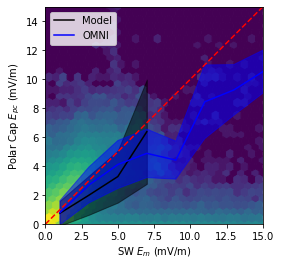

In [98]:
theta = np.arctan2(gru_df['By_gsm'], gru_df['Bz_gsm']) #Clock angle to calculate Em
B = np.sqrt(gru_df['By_gsm']**2 + gru_df['Bz_gsm']**2) #B mag perp to GSM X axis to calculate Em
V = np.sqrt(gru_df['Vx_gse']**2 + gru_df['Vy_gse']**2 + gru_df['Vz_gse']**2) #SW Velocity magnitude
Em = V * B * (np.sin(theta / 2)**2) * 1e-3 #Dawn dusk electric field

theta_omni = np.arctan2(omni_df['BY_GSM'], omni_df['BZ_GSM']) #Clock angle to calculate Em (OMNI)
B_omni = np.sqrt(omni_df['BY_GSM']**2 + omni_df['BZ_GSM']**2) #B mag perp to GSM X axis to calculate Em (OMNI)
V_omni = np.sqrt(omni_df['Vx']**2 + omni_df['Vy']**2 + omni_df['Vz']**2) #SW Velocity magnitude (OMNI)
Em_omni = V_omni * B_omni * (np.sin(theta_omni / 2)**2) * 1e-3 #Dawn dusk electric field (OMNI)

pcc = (np.where(pcc_cut['PCN'] < 0, 0, pcc_cut['PCN']) + np.where(pcc_cut['PCS'] < 0, 0, pcc_cut['PCS']))/2 #PCC is average of positive valued PCN and PCS measurements (Should it be the average?)
pcc_omni = (np.where(pcc_df_omni['PCN'] < 0, 0, pcc_df_omni['PCN']) + np.where(pcc_df_omni['PCS'] < 0, 0, pcc_df_omni['PCS']))/2 #Same as above but for OMNI

cut = (gru_df['interp_frac'] < 1) & (pcc < (999/2)) #Cut parts with 999 in PCN or PCSS values
mean_pcc, edges_pcc, binnumber = binned_statistic(Em[cut], pcc[cut], statistic = 'mean', bins = np.arange(0, 20, 2))
std_pcc, edges_pcc, binnumber = binned_statistic(Em[cut], pcc[cut], statistic = 'std', bins = np.arange(0, 20, 2))

cut_omni = (omni_df['BX_GSE'] < 999.9) & (omni_df['BY_GSM'] < 999.9) & (omni_df['BZ_GSM'] < 999.9) & (omni_df['Vx'] < 9999.9) & (omni_df['Vy'] < 9999.9) & (omni_df['Vz'] < 9999.9) & (pcc_omni < (999/2)) #OMNI data has fill values at these locations, also cut parts with 999 in PCN or PCSS values
mean_pcc_omni, edges_pcc_omni, binnumber = binned_statistic(Em_omni[cut_omni], pcc_omni[cut_omni], statistic = 'mean', bins = np.arange(0, 40, 2))
std_pcc_omni, edges_pcc_omni, binnumber = binned_statistic(Em_omni[cut_omni], pcc_omni[cut_omni], statistic = 'std', bins = np.arange(0, 40, 2))

plt.hexbin(Em_omni, pcc_omni, gridsize = 30, norm=LogNorm(), extent = (0, 15, 0, 15))
plt.plot(edges_pcc[:-1] + 1, mean_pcc, color='k', label = 'Model') #Plot model means in each bin
plt.fill_between(edges_pcc[:-1] + 1, mean_pcc + std_pcc, mean_pcc - std_pcc, alpha = 0.5, color = 'k') #Fill 1sigma range
plt.plot(edges_pcc_omni[:-1] + 1, mean_pcc_omni, color='b', label = 'OMNI')
plt.fill_between(edges_pcc_omni[:-1] + 1, mean_pcc_omni + std_pcc_omni, mean_pcc_omni - std_pcc_omni, alpha = 0.5, color = 'b')
plt.plot(np.linspace(0,32,2), np.linspace(0,32,2), linestyle='--', color='r')
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.gca().set_aspect('equal')
plt.xlabel(r'SW $E_{m}$ (mV/m)')
plt.ylabel(r'Polar Cap $E_{pc}$ (mV/m)')
plt.legend()
#plt.savefig('pcc.pdf', bbox_inches = 'tight')

<ipython-input-103-550564bb3846>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_sw[key][omni_sw[key] == omni_sw[key].max()] = np.nan
/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-103-550564bb3846>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omni_sw[key][omni_sw[key] == omni_sw[key]

Text(0.5, 0, 'Time')

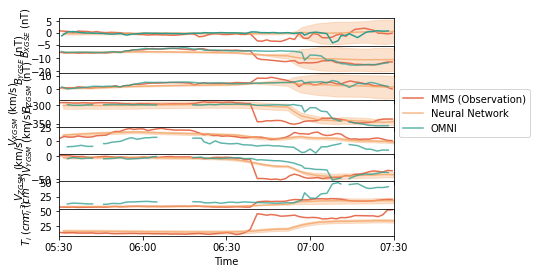

In [103]:
omni_data = pd.read_hdf(datapath + 'sw_data.h5', key = 'wind_kp_shift')
omni_sw = omni_data.iloc[ksc.closest_argmin(mms_sw['time'].to_numpy(), omni_data['time'].to_numpy())]
predict_sc = pd.read_hdf(datapath + 'sw_data.h5', key = 'gru_predict')
omni_keys = ['BX_GSE', 'BY_GSM', 'BZ_GSM', 'VX_GSE', 'VY_GSE', 'VZ_GSE', 'proton_density', 'T']
for key in omni_keys:
    omni_sw[key][omni_sw[key] == omni_sw[key].max()] = np.nan

left_time = dt.datetime(2018, 1, 8, 5, 30, tzinfo=pytz.utc).timestamp() #Left time bound
right_time = dt.datetime(2018, 1, 8, 7, 30, tzinfo=pytz.utc).timestamp() #Right time bound
mms_in_bool = ( mms_sw['time'] > left_time ) & ( mms_sw['time'] < right_time ) #Cuts all data but those in the left and right bounds
pred_in_bool = ( predict_sc['time'] > left_time ) & ( predict_sc['time'] < right_time ) #Cuts all data but those in the left and right bounds
omni_in_bool = ( omni_sw['time'] > left_time ) & ( omni_sw['time'] < right_time ) #Cuts all data but those in the left and right bounds

fig, ax = plt.subplots(nrows=8,ncols=1,sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(mms_sw['time'][mms_in_bool], mms_sw['Bx_gsm'][mms_in_bool], color=c1, alpha=1)
ax[0].plot(predict_sc['time'][pred_in_bool], predict_sc['Bx_gsm'][pred_in_bool], color=c2, alpha=0.75)
ax[0].fill_between(predict_sc['time'][pred_in_bool], predict_sc['Bx_gsm'][pred_in_bool] + predict_sc['Bx_gsm_sig'][pred_in_bool], predict_sc['Bx_gsm'][pred_in_bool] - predict_sc['Bx_gsm_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[0].plot(omni_sw['time'][omni_in_bool], omni_sw['BX_GSE'][omni_in_bool], color=c4, alpha=1)
ax[0].set_xlim(left_time, right_time)
#ax[0].set_ylim(-15, 5)
ax[0].set_ylabel(r'$B_{X GSE}$ (nT)')

ax[1].plot(mms_sw['time'][mms_in_bool], mms_sw['By_gsm'][mms_in_bool], color=c1, alpha=1)
ax[1].plot(predict_sc['time'][pred_in_bool], predict_sc['By_gsm'][pred_in_bool], color=c2, alpha=0.75)
ax[1].fill_between(predict_sc['time'][pred_in_bool], predict_sc['By_gsm'][pred_in_bool] + predict_sc['By_gsm_sig'][pred_in_bool], predict_sc['By_gsm'][pred_in_bool] - predict_sc['By_gsm_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[1].plot(omni_sw['time'][omni_in_bool], omni_sw['BY_GSM'][omni_in_bool], color=c4, alpha=0.75)
ax[1].set_xlim(left_time, right_time)
#ax[1].set_ylim(-15, 0)
ax[1].set_ylabel(r'$B_{Y GSE}$ (nT)')

ax[2].plot(mms_sw['time'][mms_in_bool], mms_sw['Bz_gsm'][mms_in_bool], color=c1, alpha=1)
ax[2].plot(predict_sc['time'][pred_in_bool], predict_sc['Bz_gsm'][pred_in_bool], color=c2, alpha=0.75)
ax[2].fill_between(predict_sc['time'][pred_in_bool], predict_sc['Bz_gsm'][pred_in_bool] + predict_sc['Bz_gsm_sig'][pred_in_bool], predict_sc['Bz_gsm'][pred_in_bool] - predict_sc['Bz_gsm_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[2].plot(omni_sw['time'][omni_in_bool], omni_sw['BZ_GSM'][omni_in_bool], color=c4, alpha=0.75)
ax[2].set_xlim(left_time, right_time)
#ax[2].set_ylim(-10, 20)
ax[2].set_ylabel(r'$B_{Z GSM}$ (nT)')

ax[3].plot(mms_sw['time'][mms_in_bool], mms_sw['Vx_gse'][mms_in_bool], color=c1, alpha=1)
ax[3].plot(predict_sc['time'][pred_in_bool], predict_sc['Vx_gse'][pred_in_bool], color=c2, alpha=0.75)
ax[3].fill_between(predict_sc['time'][pred_in_bool], predict_sc['Vx_gse'][pred_in_bool] + predict_sc['Vx_gse_sig'][pred_in_bool], predict_sc['Vx_gse'][pred_in_bool] - predict_sc['Vx_gse_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[3].plot(omni_sw['time'][omni_in_bool], omni_sw['VX_GSE'][omni_in_bool], color=c4, alpha=0.75)
#ax[3].set_ylim(-500,-400)
ax[3].set_ylabel(r'$V_{X GSM}$ (km/s)')
ax[3].legend(['MMS (Observation)', 'Neural Network', 'OMNI'], loc='center left', bbox_to_anchor=(1, 0.5))

ax[4].plot(mms_sw['time'][mms_in_bool], mms_sw['Vy_gse'][mms_in_bool], color=c1, alpha=1)
ax[4].plot(predict_sc['time'][pred_in_bool], predict_sc['Vy_gse'][pred_in_bool], color=c2, alpha=0.75)
ax[4].fill_between(predict_sc['time'][pred_in_bool], predict_sc['Vy_gse'][pred_in_bool] + predict_sc['Vy_gse_sig'][pred_in_bool], predict_sc['Vy_gse'][pred_in_bool] - predict_sc['Vy_gse_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[4].plot(omni_sw['time'][omni_in_bool], omni_sw['VY_GSE'][omni_in_bool], color=c4, alpha=0.75)
#ax[4].set_ylim(-50,50)
ax[4].set_ylabel(r'$V_{Y GSM}$ (km/s)')
#ax[4].legend(['MMS (Observation)', 'Neural Network'], loc='center left', bbox_to_anchor=(1, 0.5))

ax[5].plot(mms_sw['time'][mms_in_bool], mms_sw['Vz_gse'][mms_in_bool], color=c1, alpha=1)
ax[5].plot(predict_sc['time'][pred_in_bool], predict_sc['Vz_gse'][pred_in_bool], color=c2, alpha=0.75)
ax[5].fill_between(predict_sc['time'][pred_in_bool], predict_sc['Vz_gse'][pred_in_bool] + predict_sc['Vz_gse_sig'][pred_in_bool], predict_sc['Vz_gse'][pred_in_bool] - predict_sc['Vz_gse_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[5].plot(omni_sw['time'][omni_in_bool], omni_sw['VZ_GSE'][omni_in_bool], color=c4, alpha=0.75)
#ax[5].set_ylim(-60,20)
ax[5].set_ylabel(r'$V_{Z GSM}$ (km/s)')
#ax[5].legend(['MMS (Observation)', 'Neural Network'], loc='center left', bbox_to_anchor=(1, 0.5))

ax[6].plot(mms_sw['time'][mms_in_bool], mms_sw['n_i'][mms_in_bool], color=c1, alpha=1)
ax[6].plot(predict_sc['time'][pred_in_bool], predict_sc['n_i'][pred_in_bool], color=c2, alpha=0.75)
ax[6].fill_between(predict_sc['time'][pred_in_bool], predict_sc['n_i'][pred_in_bool] + predict_sc['n_i_sig'][pred_in_bool], predict_sc['n_i'][pred_in_bool] - predict_sc['n_i_sig'][pred_in_bool], color=c2, alpha=0.3)
ax[6].plot(omni_sw['time'][omni_in_bool], omni_sw['proton_density'][omni_in_bool], color=c4, alpha=0.75)
#ax[6].set_ylim(-5,55)
ax[6].set_ylabel(r'$n_{i}$ ($cm^{-3}$)')

ax[7].plot(mms_sw['time'][mms_in_bool], mms_sw['T_i'][mms_in_bool], color=c1, alpha=1)
ax[7].plot(predict_sc['time'][pred_in_bool], predict_sc['T_i'][pred_in_bool], color=c2, alpha=0.75)
ax[7].fill_between(predict_sc['time'][pred_in_bool], predict_sc['T_i'][pred_in_bool] + predict_sc['T_i_sig'][pred_in_bool], predict_sc['T_i'][pred_in_bool] - predict_sc['T_i_sig'][pred_in_bool], color=c2, alpha=0.3)
#ax[7].plot(omni_sw['time'][omni_in_bool], omni_sw['T'][omni_in_bool], color=c4, alpha=0.75)
#ax[7].set_ylim(-5,20)
ax[7].set_ylabel(r'$T_{i}$ ($cm^{-3}$)')

quart_delt = (right_time-left_time)/4.0
ticks = [left_time, left_time+quart_delt, left_time+2*quart_delt, left_time+3*quart_delt, left_time+4*quart_delt]
labels = [dt.datetime.fromtimestamp(left_time,tz=pytz.utc).strftime('%H:%M'),
          dt.datetime.fromtimestamp(left_time+quart_delt,tz=pytz.utc).strftime('%H:%M'),
          dt.datetime.fromtimestamp(left_time+2*quart_delt,tz=pytz.utc).strftime('%H:%M'),
          dt.datetime.fromtimestamp(left_time+3*quart_delt,tz=pytz.utc).strftime('%H:%M'),
          dt.datetime.fromtimestamp(left_time+4*quart_delt,tz=pytz.utc).strftime('%H:%M')]

ax[-1].set_xticks(ticks)
ax[-1].set_xticklabels(labels)
ax[-1].set_xticklabels(labels)
ax[-1].set_xlabel('Time')
#plt.savefig('test2.pdf', bbox_inches = 'tight')

In [8]:
#Geomagnetic indices validation
import sw_lib as sw

start = dt.datetime(2015, 9, 2, 6, tzinfo=pytz.utc)
stop = dt.datetime(2021, 4, 4, 1, tzinfo = pytz.utc)
timebins = pd.date_range(start=start, end=stop, freq='1H', tz='utc').to_list()
predict_bs['datetime'] = pd.to_datetime(predict_bs['time'], unit = 's', origin = 'unix', utc = True)
predict_bs['hourcut'] = pd.cut(predict_bs['datetime'], timebins, right = False)

dfg = predict_bs.groupby('hourcut')

predict_bs_1hr = pd.DataFrame()
predict_bs_1hr['Bx_gsm'] = dfg['Bx_gsm'].mean()
predict_bs_1hr['Bx_gsm_sig'] = dfg['Bx_gsm_sig'].mean()
predict_bs_1hr['By_gsm'] = dfg['By_gsm'].mean()
predict_bs_1hr['By_gsm_sig'] = dfg['By_gsm_sig'].mean()
predict_bs_1hr['Bz_gsm'] = dfg['Bz_gsm'].mean()
predict_bs_1hr['Bz_gsm_sig'] = dfg['Bz_gsm_sig'].mean()
predict_bs_1hr['Vx_gse'] = dfg['Vx_gse'].mean()
predict_bs_1hr['Vx_gse_sig'] = dfg['Vx_gse_sig'].mean()
predict_bs_1hr['Vy_gse'] = dfg['Vy_gse'].mean()
predict_bs_1hr['Vy_gse_sig'] = dfg['Vy_gse_sig'].mean()
predict_bs_1hr['Vz_gse'] = dfg['Vz_gse'].mean()
predict_bs_1hr['Vz_gse_sig'] = dfg['Vz_gse_sig'].mean()
predict_bs_1hr['n_i'] = dfg['n_i'].mean()
predict_bs_1hr['n_i_sig'] = dfg['n_i_sig'].mean()
predict_bs_1hr['T_i'] = dfg['T_i'].mean()
predict_bs_1hr['T_i_sig'] = dfg['T_i_sig'].mean()
predict_bs_1hr['interp_frac'] = dfg['interp_frac'].mean()

predict_bs_1hr['r_quick'] = sw.r_quick(predict_bs_1hr['n_i'], predict_bs_1hr['Vx_gse'], predict_bs_1hr['Vy_gse'], predict_bs_1hr['Vz_gse'], predict_bs_1hr['Bx_gsm'], predict_bs_1hr['By_gsm'], predict_bs_1hr['Bz_gsm'])
predict_bs_1hr['time'] = np.zeros(len(predict_bs_1hr))
for idx, interval in enumerate(predict_bs_1hr.index):
    predict_bs_1hr['time'][idx] = interval.left
predict_bs_1hr.index = pd.RangeIndex(start=0, stop=len(predict_bs_1hr), step=1)

omni_1hr = pd.read_hdf(datapath+'project.h5', key = 'omni_1hr', mode = 'a')
omni_1hr = omni_1hr[5862:54841] #Get the same time range as for predictions
omni_1hr.index = np.arange(len(omni_1hr))
omni_1hr['r_quick'] = sw.r_quick(omni_1hr['N'], -1*omni_1hr['V']*np.cos(omni_1hr['THETA-V']*2*np.pi/360)*np.cos(omni_1hr['PHI-V']*2*np.pi/360), omni_1hr['V']*np.cos(omni_1hr['THETA-V']*2*np.pi/360)*np.sin(omni_1hr['PHI-V']*2*np.pi/360), omni_1hr['V']*np.sin(omni_1hr['THETA-V']*2*np.pi/360), omni_1hr['BX_GSE'], omni_1hr['BY_GSM'], omni_1hr['BZ_GSM'])

ValueError: unsupported pickle protocol: 5

In [17]:
predict_bs_1hr['r_quick_interp'] = predict_bs_1hr['r_quick'].interpolate()
r_gru, p_gru = sps.spearmanr(omni_1hr['AP_INDEX'][1:15001], predict_bs_1hr['r_quick_interp'][0:15000])
r_omni, p_omni = sps.spearmanr(omni_1hr['AP_INDEX'][1:15001], omni_1hr['r_quick'][0:15000])
print('GRU Correlation: '+str(r_gru)+' (p='+str(p_gru)+')')
print('OMNI Correlation: '+str(r_omni)+' (p='+str(p_omni)+')')

GRU Correlation: 0.5124948726306121 (p=0.0)
OMNI Correlation: 0.5910707652232546 (p=0.0)
